In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**importing dependencies**

In [48]:
import numpy
import matplotlib.pyplot
import tensorflow
import random

**visualizing the fashion mnist data**

In [44]:
fashion_mnist = tensorflow.keras.datasets.fashion_mnist
(x_train,ytrain), (xtest, ytest) = fashion_mnist.load_data()

In [46]:
x_train.shape

(60000, 28, 28)

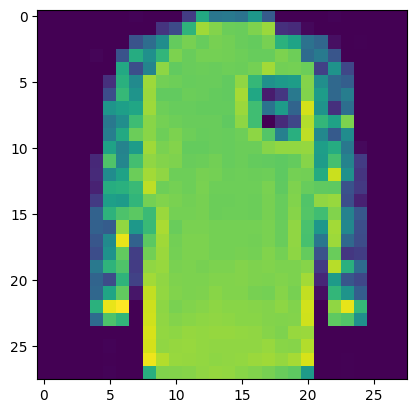

In [53]:
dev,harsh=matplotlib.pyplot.subplots()
harsh.imshow(x_train[random.randint(0,60000)])

In [3]:
import tensorflow

**making the generator**

In [4]:
generator = tf.keras.Sequential([
    #input dimension as 7x7x256
    tensorflow.keras.layers.Dense(7*7*256, input_shape=(128,)),
    tensorflow.keras.layers.Reshape((7, 7, 256)),

    tensorflow.keras.layers.Conv2D(128, 3, padding='same'),
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),

    # upsample the image to 14x14x128
    tensorflow.keras.layers.UpSampling2D(),

    tensorflow.keras.layers.Conv2D(128, 3, padding='same'),  # Output shape: 14x14x128
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),

    # Up-sample to 28x28x64
    tensorflow.keras.layers.UpSampling2D(),

    tensorflow.keras.layers.Conv2D(64, 3, padding='same'),
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),

    tensorflow.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')
])

**initial prediction from generator without training**

In [5]:
w=generator.predict(tensorflow.random.normal(shape=(4,128)))

1/1 [==============================] - 0s 205ms/step


In [6]:
w.shape

(4, 28, 28, 1)

In [ ]:
tensorflow.random.normal(shape=(4,128))

<tf.Tensor: shape=(4, 128), dtype=float32, numpy=
array([[ 2.20212579e-01, -1.18502855e+00, -3.17322277e-02,
         1.65164244e+00,  1.31032169e+00,  1.72408736e+00,
         1.94526947e+00,  1.03904510e+00,  9.95868087e-01,
         1.31797290e+00, -2.27579737e+00, -7.03307800e-03,
        -2.79419351e+00,  2.21117997e+00, -2.05427751e-01,
        -1.59366143e+00, -1.20108497e+00, -6.75325096e-02,
         1.60840642e+00, -5.48992157e-01, -1.17939484e+00,
        -1.15934384e+00, -4.17499356e-02, -1.05612755e+00,
         2.28877544e-01,  2.83670044e+00, -9.87565875e-01,
         9.79071200e-01, -4.91853982e-01,  1.05418253e+00,
        -6.22515023e-01,  3.48207414e-01, -8.25281888e-02,
         1.31425470e-01,  1.69483840e+00,  9.27576065e-01,
         1.30257547e-01, -1.10637814e-01,  8.82515490e-01,
        -1.12993300e+00,  1.28450239e+00, -4.87839758e-01,
         8.67413163e-01, -4.46394563e-01, -5.56932926e-01,
        -2.21065044e-01, -1.46356440e+00,  5.44778526e-01,
      

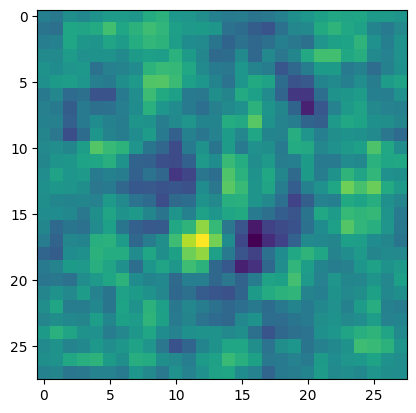

In [7]:
dev,harsh=matplotlib.pyplot.subplots()
harsh.imshow(numpy.squeeze(w[1]))

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1618176   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         295040    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       147584    
                                                        

**making the discriminator**

In [9]:
discriminator=tensorflow.keras.Sequential([
    tensorflow.keras.layers.Conv2D(64,3,padding='same'),
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.Conv2D(64,3,padding='same'),
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),
    tensorflow.keras.layers.BatchNormalization(),

    tensorflow.keras.layers.Conv2D(64,3,padding='same'),
    tensorflow.keras.layers.LeakyReLU(alpha=0.2),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(1,activation='sigmoid')
])

In [10]:
discriminator.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),loss=tensorflow.keras.losses.BinaryCrossentropy())

**combining the generator and discriminator to a single sequential model**

In [12]:
gan=tensorflow.keras.Sequential([generator,discriminator])

In [13]:
gan.compile(optimizer=tensorflow.keras.optimizers.Adam(),loss=tensorflow.keras.losses.BinaryCrossentropy())

**the generator layer**

In [27]:
gan.layers[0]

**the discriminator layer**

In [28]:
gan.layers[1]

**importing the tqdm for moinitoring the progress of training**

In [16]:
from tqdm import tqdm

**making the training function**

In [14]:
def train_gan(model,dataset,epochs,noise_size,batch_size):

    #extracting the generator
    generator=gan.layers[0]


    #extracting the discriminator
    discriminator=gan.layers[1]

    for epoch in range(epochs):

        print(f'running {epoch} / {epochs}')

        for steps,X_batch in enumerate(tqdm(dataset)):

            #generating the fake images from generator

            fake=generator(tensorflow.random.normal(shape=[batch_size,noise_size]))

            Train=tensorflow.concat([X_batch,fake],axis=0)

            label_real = tensorflow.ones((batch_size, 1))
            label_fake = tensorflow.zeros((batch_size, 1))

            label=tensorflow.concat([label_real, label_fake],axis=0)

            discriminator.traniable=True
            d_loss=discriminator.train_on_batch(Train,label)
            noise = tf.random.normal(shape=[batch_size, noise_size])
            y2=tensorflow.concat([[1]]*batch_size,axis=0)
            discriminator.trainable=False
            g_loss=gan.train_on_batch(noise,y2)

            if steps % 100==0:
                print(f'step{steps} generator_loss{g_loss} discriminator_loss{g_loss}')
        print(f"Epoch {epoch+1} completed: d_loss={d_loss}, g_loss={g_loss}")

In [17]:
def load_and_preprocess():
    (x_train,y_train), (x_test,y_test) = tensorflow.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train= numpy.expand_dims(x_train, axis=-1)
    dataset = tensorflow.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 128
dataset = load_and_preprocess()

train_gan(gan, dataset,epochs=5,noise_size=128,batch_size=batch_size)

running 0 / 5


  0%|          | 1/468 [00:03<29:28,  3.79s/it]

step0 generator_loss1.1116001605987549 discriminator_loss1.1116001605987549


 22%|██▏       | 101/468 [01:05<03:42,  1.65it/s]

step100 generator_loss1.0138859441274255e-15 discriminator_loss1.0138859441274255e-15


 43%|████▎     | 201/468 [02:05<02:38,  1.69it/s]

step200 generator_loss2.4783358179537255e-16 discriminator_loss2.4783358179537255e-16


 64%|██████▍   | 301/468 [03:07<01:46,  1.57it/s]

step300 generator_loss1.1315301384133385e-16 discriminator_loss1.1315301384133385e-16


 86%|████████▌ | 401/468 [04:10<00:41,  1.60it/s]

step400 generator_loss5.030483013373477e-17 discriminator_loss5.030483013373477e-17


100%|██████████| 468/468 [04:52<00:00,  1.60it/s]


Epoch 1 completed: d_loss=0.00017375803145114332, g_loss=2.2959794182283273e-17
running 1 / 5


  0%|          | 1/468 [00:00<05:09,  1.51it/s]

step0 generator_loss2.271829053064229e-17 discriminator_loss2.271829053064229e-17


 22%|██▏       | 101/468 [01:03<03:50,  1.60it/s]

step100 generator_loss9.38960010269156e-18 discriminator_loss9.38960010269156e-18


 43%|████▎     | 201/468 [02:06<02:46,  1.60it/s]

step200 generator_loss9.997918651330407e-18 discriminator_loss9.997918651330407e-18


 64%|██████▍   | 301/468 [03:10<01:45,  1.58it/s]

step300 generator_loss5.326808225547533e-18 discriminator_loss5.326808225547533e-18


 86%|████████▌ | 401/468 [04:13<00:43,  1.55it/s]

step400 generator_loss4.330897657284714e-18 discriminator_loss4.330897657284714e-18


100%|██████████| 468/468 [04:56<00:00,  1.58it/s]


Epoch 2 completed: d_loss=2.6368048369751484e-11, g_loss=1.766016959320607e-18
running 2 / 5


  0%|          | 1/468 [00:00<05:23,  1.44it/s]

step0 generator_loss1.531484268894339e-18 discriminator_loss1.531484268894339e-18


 22%|██▏       | 101/468 [01:03<03:57,  1.54it/s]

step100 generator_loss2.4405413898269734e-18 discriminator_loss2.4405413898269734e-18


 43%|████▎     | 201/468 [02:06<02:42,  1.65it/s]

step200 generator_loss7.670541979950435e-19 discriminator_loss7.670541979950435e-19


 64%|██████▍   | 301/468 [03:09<01:44,  1.60it/s]

step300 generator_loss4.2487997746936727e-19 discriminator_loss4.2487997746936727e-19


 86%|████████▌ | 401/468 [04:10<00:40,  1.66it/s]

step400 generator_loss5.610290466094969e-19 discriminator_loss5.610290466094969e-19


100%|██████████| 468/468 [04:50<00:00,  1.61it/s]


Epoch 3 completed: d_loss=2.665638705861423e-13, g_loss=4.2928874673669833e-19
running 3 / 5


  0%|          | 1/468 [00:00<05:17,  1.47it/s]

step0 generator_loss3.8267719676751765e-19 discriminator_loss3.8267719676751765e-19


 22%|██▏       | 101/468 [01:00<03:40,  1.66it/s]

step100 generator_loss2.793496203577265e-19 discriminator_loss2.793496203577265e-19


 43%|████▎     | 201/468 [01:59<02:36,  1.70it/s]

step200 generator_loss3.629539280911974e-19 discriminator_loss3.629539280911974e-19


 64%|██████▍   | 301/468 [02:57<01:37,  1.72it/s]

step300 generator_loss3.1409645351196454e-19 discriminator_loss3.1409645351196454e-19


 86%|████████▌ | 401/468 [03:56<00:39,  1.71it/s]

step400 generator_loss2.5575819664316686e-19 discriminator_loss2.5575819664316686e-19


100%|██████████| 468/468 [04:35<00:00,  1.70it/s]


Epoch 4 completed: d_loss=1.0510021672405223e-12, g_loss=2.247775426672769e-19
running 4 / 5


  0%|          | 1/468 [00:00<05:11,  1.50it/s]

step0 generator_loss1.6200108699591716e-19 discriminator_loss1.6200108699591716e-19


 22%|██▏       | 101/468 [00:59<03:33,  1.72it/s]

step100 generator_loss1.9507720918325416e-19 discriminator_loss1.9507720918325416e-19


 43%|████▎     | 201/468 [01:57<02:35,  1.71it/s]

step200 generator_loss8.273512185543667e-20 discriminator_loss8.273512185543667e-20


 64%|██████▍   | 301/468 [02:56<01:37,  1.70it/s]

step300 generator_loss1.2128574505649982e-19 discriminator_loss1.2128574505649982e-19


 86%|████████▌ | 401/468 [03:54<00:38,  1.73it/s]

step400 generator_loss9.961849854310338e-20 discriminator_loss9.961849854310338e-20


100%|██████████| 468/468 [04:33<00:00,  1.71it/s]

Epoch 5 completed: d_loss=7.65392003249099e-12, g_loss=1.2462035567494542e-19


In [18]:
import matplotlib.pyplot as plt

In [26]:
generated_images = generator.predict(tensorflow.random.normal([4,128]))

1/1 [==============================] - 0s 29ms/step


**it is necessary to run the gan over 1000 epochs but we have only run it over 5 epochs but it started to learn pattern and tried to develop a image**

Text(0.5, 1.0, 'Generated')

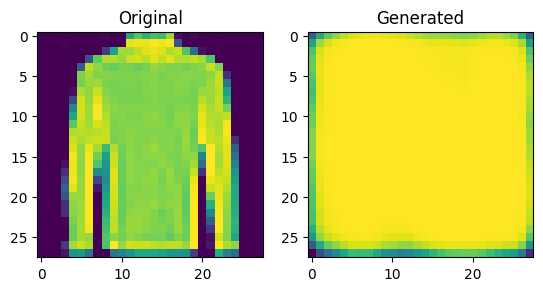

In [60]:
dev,(harsh1,harsh2)=matplotlib.pyplot.subplots(nrows=1,ncols=2)
harsh1.imshow(x_train[random.randint(0,60000)])
harsh2.imshow(generated_images[2])
harsh1.set_title('Original')
harsh2.set_title('Generated')

In [77]:
from google.colab.patches import cv2_imshow
import cv2

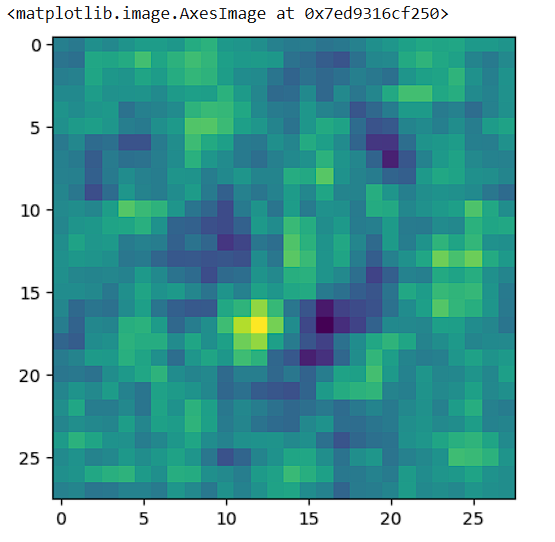

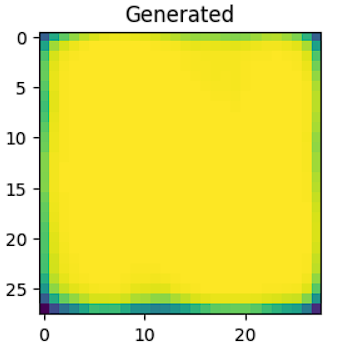

In [79]:
img1=cv2.imread('/content/before.png')
img2=cv2.imread('/content/after.png')
cv2_imshow(img1)
cv2_imshow(img2)

In [41]:
import uuid
print(uuid.uuid1())

09c677f2-4535-11ef-bc12-0242ac1c000c
